In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Parameters
image_folder = "images_unlabeled"
img_size = (128, 128)

# Load and preprocess images
def load_images(folder):
    data = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            try:
                img = Image.open(path).convert('L')  # grayscale
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0  # normalize
                data.append(img_array)
            except Exception as e:
                print(f"❌ Error loading {filename}: {e}")
    return np.array(data)

# Load data
images = load_images(image_folder)

# Reshape to include channel dimension
images = np.expand_dims(images, axis=-1)  # shape: (num_samples, 128, 128, 1)

# Train/val split
X_train, X_val = train_test_split(images, test_size=0.2, random_state=42)

# Save for training
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)

print(f"✅ Preprocessing done. Shapes: Train = {X_train.shape}, Val = {X_val.shape}")

✅ Preprocessing done. Shapes: Train = (92, 128, 128, 1), Val = (24, 128, 128, 1)


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load preprocessed data
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")

# Input shape
input_shape = X_train.shape[1:]

# === Build the Autoencoder ===
input_img = Input(shape=input_shape)

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Summary
autoencoder.summary()

# Callbacks
checkpoint = ModelCheckpoint("autoencoder_model.keras", save_best_only=True, monitor="val_loss", mode="min")
earlystop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train
history = autoencoder.fit(
    X_train, X_train,
    epochs=25,
    batch_size=16,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[checkpoint, earlystop]
)

print("✅ Model training complete and saved as autoencoder_model.h5")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - loss: 0.6917 - val_loss: 0.6875
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.6839 - val_loss: 0.6708
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.6604 - val_loss: 0.6257
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.6091 - val_loss: 0.6030
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.5969 - val_loss: 0.5974
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.5915 - val_loss: 0.5970
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.5913 - val_loss: 0.5938
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.5894 - val_loss: 0.5920
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.5870 - val_loss: 0.5910
Epoch 10/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.5869 - val_loss: 0.5903
Epoch 11/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.5780 - val_loss: 0.5898
Epoch 12/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.5822 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Image 1 — Error: 0.00389 — Status: Abnormal
Image 2 — Error: 0.00221 — Status: Normal
Image 3 — Error: 0.00344 — Status: Abnormal
Image 4 — Error: 0.00150 — Status: Normal
Image 5 — Error: 0.00231 — Status: Normal


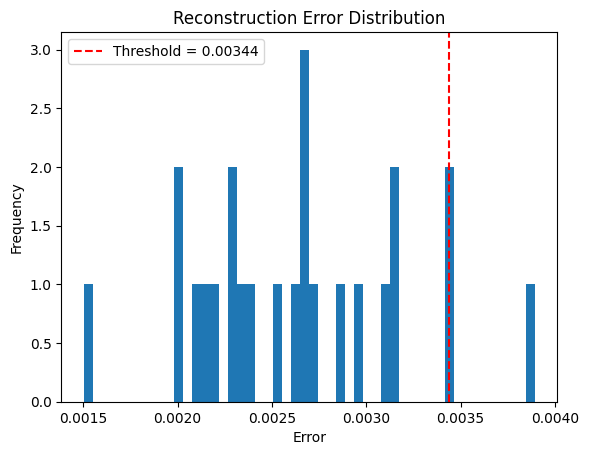

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load model
model = tf.keras.models.load_model("autoencoder_model.keras")

# Load validation set
X_val = np.load("X_val.npy")

# Predict (reconstruct)
X_pred = model.predict(X_val)

# Compute reconstruction error (MSE)
errors = np.mean((X_val - X_pred) ** 2, axis=(1, 2, 3))

# Set threshold (e.g., 95th percentile of errors = cutoff)
threshold = np.percentile(errors, 95)

# Flag as abnormal if error > threshold
labels = np.where(errors > threshold, "Abnormal", "Normal")

# View sample results
for i in range(5):
    print(f"Image {i+1} — Error: {errors[i]:.5f} — Status: {labels[i]}")

# Optional: plot histogram of errors
plt.hist(errors, bins=50)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.5f}')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()